In [1]:
import numpy as np
import matplotlib.pyplot as plt

(a)

From a previous Homework,we find the optimal set of parameters $ \sigma,\nu_{0},\kappa,\rho,\theta $ converges to [2.18,  0.05,  4.11, -0.8,  0.07]

In [2]:
sigma = 1.9
v0 = 0.05 
k = 3.65
rho = -0.8
theta = 0.07
q = 0.0177
r = 0.015
T = 1
S0 =282
K = 285

(b)

In [3]:
def simulation(sigma=2.18, v0=0.05, k=4.11, rho=-0.8, theta=0.07, q=0.0177, r=0.015, S0=282, T=1, steps=100, paths=10000):
    S = np.zeros((steps + 1, paths))
    S[0] = S0
    v = np.zeros((steps + 1, paths))
    v[0] = v0
    dt = T / steps
    N = paths
    for t in range(1, steps + 1):
        z1 = np.random.standard_normal(N)
        z2 = np.random.standard_normal(N)
        x1 = 0 + np.sqrt(dt)*z1
        x2 = 0 + np.sqrt(dt)*(rho*z1 + np.sqrt(1-rho**2)*z2)
        v[t] = np.maximum(v[t-1] + k*(theta-v[t-1])*dt + sigma*np.sqrt(v[t-1])*x2,0) # Truncate
        #v[t] = np.abs(v[t-1] + k*(theta-v[t-1])*dt + sigma*np.sqrt(v[t-1])*x2) # Reflect
        S[t] = S[t-1] + (r-q)*S[t-1]*dt + np.sqrt(v[t-1])*S[t-1]*x1
#     X = np.linspace(0, 1, steps + 1, endpoint=True)
#     for i in range(N):
#         plt.plot(X, S[:, i])
#     plt.show()
    M = [max(S[:,i]) for i in range(N)]
    return S,M

In [4]:
S,M = simulation(sigma=sigma,v0=v0,k=k,rho=rho,q=q,r=r,S0=S0)

In [5]:
def calc_simulated_price(r,T,S,K):
    payoff = np.maximum(S[-1] - K,0)
    return np.exp(-(r+q)*T) * np.mean(payoff)

In [6]:
c0 = calc_simulated_price(r,T,S,K)
print(c0)

24.55846851472905


(c)

In [7]:
#FFT
def characteristic_function(u,t,sigma=0.2,v0=0.08,k=0.7,rho=-0.4,theta=0.1,r=0.02,S0=250,q=0):
    Lambda = np.sqrt((sigma ** 2) * (complex(u ** 2, u)) + (complex(k, -rho * sigma * u)) ** 2)
    omega = np.exp(complex(0, u * (np.log(S0) + (r - q) * t)) + k * theta * t * complex(k, -rho * sigma * u) / sigma ** 2) \
            / (np.cosh(Lambda * t / 2) + (complex(k, -rho * sigma * u) / Lambda) * np.sinh(Lambda * t / 2)) ** (2 * k * theta / sigma ** 2)
    phi = omega * np.exp(-(complex(u ** 2, u)) * v0 / (Lambda / np.tanh(Lambda * t / 2) + complex(k, -rho * sigma * u)))
    return phi


def fft(K=250, n=10, alpha=1, UB=500, t=0.5, sigma=0.2, v0=0.08, k=.7, rho=-0.4, theta=0.1, r=0.015, q=0.0177,
        S0=267.15):
    N = 2 ** n
    B = UB

    v = np.linspace(0, B, N + 1)[0:-1]
    delta_v = B / N

    delta_k = 2 * np.pi / B
    beta = np.log(S0) - delta_k * N / 2
    km = beta + (np.linspace(0, N, N + 1)[0:-1]) * delta_k

    x = []
    for j in range(N):
        if j == 0:
            wj = 0.5
        else:
            wj = 1

        phi = characteristic_function(complex(v[j], -(alpha + 1)), t, sigma, v0, k, rho, theta, r, S0, q)
        xj = phi * np.exp(complex(0, -beta) * v[j]) * wj * delta_v / \
             (complex(alpha, v[j])) / complex(alpha + 1, v[j])
        x.append(xj)
    x = np.array(x) * np.exp(-r * t)
    y = np.fft.fft(x)

    call_price = []
    for j in range(N):
        c = np.exp(-alpha * (np.log(S0) - delta_k * (N / 2 - j))) * np.real(y[j]) / np.pi
        call_price.append(c)

    return np.exp(km), call_price

def call_price(sigma, v0, k, rho, theta,K=250,n=10,alpha=1,UB=600,t=0.5,r = 0.015,q = 0.0177,S0 = 267.15):
    K_list, price_list = fft(K,n,alpha,UB,t,sigma, v0, k, rho, theta,r,q,S0)
    return np.interp(K, K_list, price_list)

In [8]:
c = call_price(sigma=sigma, v0=v0, k=k, rho=rho, theta=theta,K=K,n=10,alpha=1,UB=600,t=T,r =r,q=q,S0=S0)
print(c)

18.523241425992904


(d)

In [9]:
S

array([[282.        , 282.        , 282.        , ..., 282.        ,
        282.        , 282.        ],
       [274.76894579, 285.44101446, 275.1948234 , ..., 276.25000647,
        283.1208442 , 282.33285733],
       [281.36380263, 277.25675866, 276.1938813 , ..., 270.35049365,
        282.42437314, 281.73430153],
       ...,
       [247.04984827, 287.35186776, 348.33992169, ..., 224.79679766,
        242.8930044 , 323.88981005],
       [249.30406366, 300.68543394, 348.48274941, ..., 224.79072814,
        241.06968775, 323.83416859],
       [247.6837165 , 300.67731543, 348.44224231, ..., 224.64216035,
        233.29315747, 327.30072516]])

In [10]:
def up_and_out(r,T,S,M,K1,K2):
    payoff = np.maximum(S[-1] - K1,0)
    sign = [m<K2 for m in M]
    return np.exp(-(r+q)*T)*np.mean(payoff*sign)

In [20]:
K1 = 285
K2 = 315
c1 = up_and_out(r,T,S,M,K1,K2)
print(c1)

1.3091576347413627


(e)

In [12]:
def control_variate(r,T,S,M,K1,K2):
    payoff = np.maximum(S[-1] - K1,0)
    sign = [m<K2 for m in M]
    hx = payoff*sign
    Z = np.maximum(S[-1] - K1,0)
    c = -np.cov(hx,Z)[0][1]/np.var(Z)
    theta_hat = hx + c*(Z-np.mean(Z))
    return np.exp(-(r+q)*T)*np.mean(theta_hat)

In [13]:
c2 =control_variate(r,T,S,M,K1,K2)
print(c2)

1.3379935094701219


-1.02560833224072
-1.1266503587920917
-1.0744594644717205


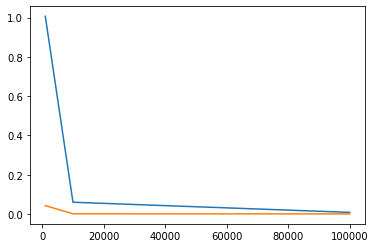

In [21]:
K1 = 285
K2 = 500
Theta = []
Theta_hat = []
N = [10**i for i in range(3,6)]
times = 10
j = 0
i = 0
theta = []
z = []
while j <len(N):
    n = N[j]
    i = 0
    while i<times:
        S,M = simulation(sigma=sigma,v0=v0,k=k,rho=rho,q=q,r=r,S0=S0,T=T,paths=n)
        hx = np.maximum(S[-1] - K1,0)*[m<K2 for m in M]
        theta += [np.mean(hx)]
        euro_call = np.mean(np.maximum(S[-1] - K1,0))
        z += [euro_call]
        i += 1
    c = -np.cov(theta,z)[0][1]/np.var(z)
    print(c)
    theta_hat = theta + c*(z-np.mean(z))
    Theta.append(np.var(theta))
    Theta_hat.append(np.var(theta_hat))
    j += 1
    theta.clear()
    z.clear()
plt.plot(N,Theta)
plt.plot(N,Theta_hat)
plt.show()